### Notebook 3

#### KNN Modeling + Deployment (app.py)

- More or less as same code as app.py with few differences. 
- One for jupyter notebook and one for streamlit app. 

In [1]:
#Import the necessary libraries
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
from dotenv import load_dotenv
load_dotenv()
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing
import xgboost

# Access the api with token
# scope = "user-library-read"
# sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))


# Access the api without token
client_credentials_manager = SpotifyClientCredentials()
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [2]:
# Convert a song_id to a dataframe row
def song_to_df (sp, key):
    """
    Convert a song to a dataframe row

    Parameters:
    sp (Spotify Object): Authorized SpotifyOAuth object
    key (str): Spotify ID of the song

    Returns:
    DataFrame: Row of a song converted to dataframe
    """
    cat_cols = ['key', 'mode', 'time_signature']
    num_cols = ['danceability','energy','loudness','speechiness','acousticness',
                'instrumentalness','liveness','valence','tempo','duration_ms']
    
    row = pd.DataFrame(sp.audio_features(key)).drop(['type','uri',
                                               'track_href','analysis_url'], axis=1).set_index('id')
    return row

# Do preprocessing and make a genre prediction for a song 
def make_genre_prediction(sp,key, ohe, model):
    """
    Make a prediction for genre for a song

    Parameters:
    sp (Spotify Object): Authorized SpotifyOAuth object
    key (str): Spotify ID of the song
    ohe (One Hot Encoder): Fitted one hot encoder object for preprocessing
    model: Model used to make genre prediction

    Returns:
    str: genre prediction
    """
    cat_cols = ['key', 'mode', 'time_signature']
    num_cols = ['danceability','energy','loudness','speechiness','acousticness',
                'instrumentalness','liveness','valence','tempo','duration_ms']
    row = song_to_df(sp,key)
    temp_ohe = ohe.transform(row[cat_cols])
    returning_obj = row[num_cols].reset_index().join(pd.DataFrame(temp_ohe)).set_index('id')
    return model.predict(returning_obj)

# Get the song info from song_id
def song_artist_from_key(sp,key):
    """
    Get name and song from a song ID

    Parameters:
    sp (Spotify Object): Authorized SpotifyOAuth object
    key (str): Spotify ID of the song

    Returns:
    tuple: Tuple containing a song's title, artist's title, Spotify link
    """
    theTrack = sp.track(key)
    song_title = theTrack['name']
    artist_title = theTrack['artists'][0]['name']
    song_link = theTrack['external_urls']['spotify']
    return (song_title, artist_title, song_link)

# Get the song id from a query
def song_id_from_query(sp, query):
    """
    Get the Spotify ID from a song from a user entry

    Parameters:
    sp (Spotify Object): Authorized SpotifyOAuth object
    query (str): Query of song: Usually containing Song name and/or Artist name

    Returns:
    JSON: JSON object containing song attributes
    None: If song wasn't found
    """
    q = query
    if(sp.search(q, limit=1, offset=0, type='track')['tracks']['total']>0):
        return sp.search( q, limit=1, offset=0, type='track')['tracks']['items'][0]['id']
    else:
        return None

In [3]:
# Import necessary pickled files
infile = open('pickled_files/all_songs_genre_predicted.pickle','rb')
all_files = pickle.load(infile)
infile.close()
# df.set_index('id', inplace = True)
all_songs = all_files[0]
best_model = all_files[1]
ohe_make_genre_pred = all_files[2]

In [4]:
# Create variables to easily access categorical and numerical columns
categorical_columns = list(all_songs.select_dtypes('object').columns)
numerical_columns = list(all_songs.select_dtypes(exclude = 'object').columns)

In [5]:
all_songs.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,predicted_genre
id,,,,,,,,,,,,,,
4g6ulcIKVvL0IAyPIRhGBq,0.353,0.499,7,-5.830,1,0.0330,0.00144,0.721000,0.1600,0.191,143.568,247667.0,4,alt-metal
0R7Gz7fHik0A9kklCAzAWj,0.495,0.791,10,-5.532,1,0.0372,0.02410,0.000079,0.1640,0.127,128.062,241447.0,4,pop
2MNQMtZbOb7rBWli3TSok0,0.788,0.594,6,-4.864,0,0.3360,0.02490,0.000017,0.0534,0.691,83.840,228907.0,4,hip-hop
3muBQDekYAg7jm6hDu6R0Z,0.587,0.711,1,-6.330,1,0.4200,0.17100,0.000000,0.1250,0.381,98.008,254694.0,4,hip-hop
73F87Sqh6jQWucOOvz1WFx,0.622,0.621,11,-4.924,0,0.1290,0.08640,0.000098,0.1210,0.567,158.946,213040.0,4,hip-hop


In [6]:
import seaborn as sns

In [7]:
# See correlation
pd.get_dummies(all_songs).corr()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,...,mode_0,mode_1,time_signature_1,time_signature_3,time_signature_4,time_signature_5,predicted_genre_alt-metal,predicted_genre_hip-hop,predicted_genre_pop,predicted_genre_rock
danceability,1.000000,-0.170135,0.038619,0.247037,0.029202,-0.232641,-0.211566,0.450075,-0.163735,-0.111473,...,0.081772,-0.081772,-0.056574,-0.178209,0.185863,-0.038208,-0.490248,0.576142,0.032852,-0.201703
energy,-0.170135,1.000000,0.713957,-0.023518,-0.579287,-0.044195,0.138529,0.082810,0.125074,0.110226,...,0.005378,-0.005378,-0.048338,-0.100970,0.124810,-0.049817,0.436258,-0.082496,-0.117653,-0.284705
loudness,0.038619,0.713957,1.000000,-0.065552,-0.471734,-0.196298,-0.001048,0.046139,0.060684,0.141405,...,0.041464,-0.041464,-0.054913,-0.119755,0.154868,-0.074598,0.273757,0.085906,0.070782,-0.460405
speechiness,0.247037,-0.023518,-0.065552,1.000000,0.094166,-0.209224,0.079683,0.167824,-0.039792,-0.147690,...,0.052291,-0.052291,0.043308,-0.014927,-0.076851,0.150479,-0.233791,0.602315,-0.240707,-0.304010
acousticness,0.029202,-0.579287,-0.471734,0.094166,1.000000,-0.014213,-0.007778,0.038245,-0.108409,-0.169348,...,-0.015740,0.015740,0.047094,0.090278,-0.114569,0.047877,-0.353566,0.012172,0.207932,0.211684
instrumentalness,-0.232641,-0.044195,-0.196298,-0.209224,-0.014213,1.000000,-0.034010,-0.196048,0.033715,0.042294,...,-0.024411,0.024411,0.020994,0.054172,-0.054263,0.004458,0.251449,-0.244878,-0.089639,0.096883
liveness,-0.211566,0.138529,-0.001048,0.079683,-0.007778,-0.034010,1.000000,-0.095678,-0.017067,0.048426,...,-0.014834,0.014834,0.012528,0.013234,-0.027812,0.025410,0.131787,-0.055778,-0.050559,-0.036255
valence,0.450075,0.082810,0.046139,0.167824,0.038245,-0.196048,-0.095678,1.000000,-0.041709,-0.168380,...,0.030244,-0.030244,-0.009793,-0.136906,0.136486,-0.039951,-0.352761,0.240996,-0.046361,0.123554
tempo,-0.163735,0.125074,0.060684,-0.039792,-0.108409,0.033715,-0.017067,-0.041709,1.000000,0.007804,...,-0.052372,0.052372,-0.044042,0.067744,-0.034714,-0.012740,0.099707,-0.137197,-0.025668,0.080422
duration_ms,-0.111473,0.110226,0.141405,-0.147690,-0.169348,0.042294,0.048426,-0.168380,0.007804,1.000000,...,0.044108,-0.044108,-0.020117,-0.020236,0.032769,-0.018444,0.077057,-0.071637,-0.021997,0.021259


<AxesSubplot:>

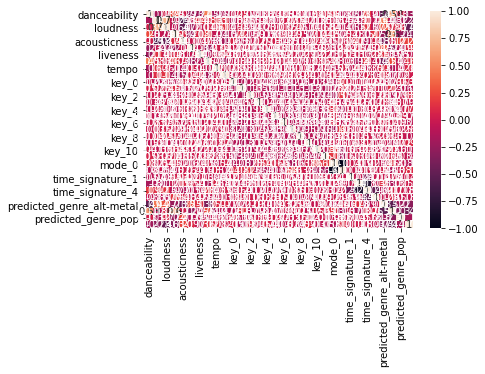

In [8]:
# See correlation
sns.heatmap(pd.get_dummies(all_songs).corr(), annot= True)

In [9]:
len(pd.get_dummies(all_songs).columns)

32

In [10]:
((pd.get_dummies(all_songs).corr()>.75).sum().values).sum()

32

Correlation matrixes were too hard to read so to easily read it, compare the total amount of columns vs the amount of correlation scores greater than .75. If they are the same value, no correlation score above .75. If the true matrix sum is greater than the amount of columns, we have to address multicollinearity. 

In [11]:
# Create a nearest neighbors object using cosine similarity metric.
neigh = NearestNeighbors(n_neighbors=15, radius=0.45, metric='cosine')

In [12]:
X_knn = all_songs

In [13]:
# Total dataframe normalizing for nearest neighbors
MMScaler = preprocessing.MinMaxScaler()
MinMaxScaler = preprocessing.MinMaxScaler()
X_knn[numerical_columns] = MinMaxScaler.fit_transform(X_knn[numerical_columns])


In [14]:
# Total dataframe dummying
ohe_knn = OneHotEncoder(drop='first', sparse=False)
X_knn_ohe = ohe_knn.fit_transform(X_knn[categorical_columns])
X_knn_transformed = X_knn[numerical_columns].reset_index().join(pd.DataFrame(X_knn_ohe, columns = ohe_knn.get_feature_names(categorical_columns))).set_index('id')


In [15]:
# Fit the model
neigh.fit(X_knn_transformed)

NearestNeighbors(metric='cosine', n_neighbors=15, radius=0.45)

In [16]:
categorical_columns

['key', 'mode', 'time_signature', 'predicted_genre']

In [17]:
# Do proper preprocessing for a single song
def knn_preprocessing(sp, key, num_col = numerical_columns, 
                      cat_col = categorical_columns,
                      mmScaler = MinMaxScaler, bm = best_model,
                      ohe_knn = ohe_knn, ohe_make_genre_pred = ohe_make_genre_pred):
    """
    Preprocessing for a song

    Parameters:
    sp (Spotify Object): Authorized SpotifyOAuth object
    key (str): Key of Spotify Song
    num_col (list): List of Strings of numerical columns for preprocessing
    cat_col (list): List of Strings of categorical columns for preprocessing
    mmScaler (MinMaxScaler Object): MinMaxScaler for normalization of numerical columns
    bm (Model): Model to make genre prediction
    ohe_knn (One Hot Encoder): One hot encoder object fitted for KNN transformation
    ohe_make_genre_pred (One Hot Encoder): One hot encoder object fitted for genre prediction

    Returns:
    DataFrame: Row of inputted song after cleaning
    """
    # Convert song to the dataframe
    row = song_to_df(sp, key)
    # Make genre prediction for inputted song
    genre = make_genre_prediction(sp,key, ohe_make_genre_pred, bm)
    # Append the predicted genre
    row['predicted_genre'] = genre[0]
    # Dummy the categorical
    row_dummied = ohe_knn.transform(row[cat_col])
    # Normalize the numerical
    row[num_col] = mmScaler.transform(row[num_col])
    # Combine the preprocessed rows and return it
    row = row[num_col].reset_index().join(pd.DataFrame(row_dummied, columns = ohe_knn.get_feature_names(cat_col))).set_index('id')
    return row

In [18]:
def make_song_recommendations(sp, kneighs, query):
    """
    Takes query and generates a [playlist] of recommended songs

    Parameters:
    sp (Spotify Object): Authorized SpotifyOAuth object
    kneighs (NearestNeighbors): Fitted nearest neighbors object to predict similar songs
    query (str): String containing song title and/or artist title to make similar songs prediction

    Returns:
    List: List containing similar song predictions, including song title, artist title, and Spotify link
    """
    #If the query is aspace or not filled, return no results
    if(query.isspace() or not query):
        return "No results found"
    song_id = song_id_from_query(sp, query)
    # If the query doesn't return an id, return no results
    if(song_id == None):
        return "No results found"
    # Get the song info
    song_plus_artist = song_artist_from_key(sp, song_id)
    # Preprocess the tracks
    song_to_rec = knn_preprocessing(sp, song_id)
    # Get the 15 nearest neighbors to inputted song
    nbrs = neigh.kneighbors(
       song_to_rec, 15, return_distance=False
    )
    # Properly retrieve the song info of each neighbor and return it
    playlist = []
    for each in nbrs[0]:
        the_rec_song = song_artist_from_key(sp, X_knn_transformed.iloc[each].name)
        if (((the_rec_song[0:2]) != song_plus_artist[0:2]) and
           ((the_rec_song[0:2]) not in playlist)):
            playlist.append(song_artist_from_key(sp, X_knn_transformed.iloc[each].name))
    return (playlist)

In [19]:
# Get the ID from query
song_id_from_query(sp, "regulate warren g")

'7nYvUtkQMx1v80S2FH2s9J'

In [20]:
# Knowledge check to see if it matches
song_artist_from_key(sp, '7nYvUtkQMx1v80S2FH2s9J')

('Regulate',
 'Warren G',
 'https://open.spotify.com/track/7nYvUtkQMx1v80S2FH2s9J')

In [21]:
# Make the genre prediction
make_genre_prediction(sp, '7nYvUtkQMx1v80S2FH2s9J', ohe_make_genre_pred, best_model)[0]

'hip-hop'

In [22]:
# Make the song recommendations
make_song_recommendations(sp, neigh, "regulate warren g")

[('untitled 08 | 09.06.2014.',
  'Kendrick Lamar',
  'https://open.spotify.com/track/5bBUDJUfGcG7eFy3Bf4fXv'),
 ("Crush on You (feat. Lil' Cease) - Remix",
  "Lil' Kim",
  'https://open.spotify.com/track/2LP2uDQQ7eLMcUVE4aOpAV'),
 ('Millennium',
  'Outkast',
  'https://open.spotify.com/track/50Fp9rUhDZvGJ4UUz4mTwp'),
 ('Free Lunch',
  'Isaiah Rashad',
  'https://open.spotify.com/track/5FX89IUKm9QJT9ymrmyK4k'),
 ('Enjoy da Ride',
  'Busta Rhymes',
  'https://open.spotify.com/track/0PceGMtVEhudGibQ6Qjo0H'),
 ('Fuck The World',
  '2Pac',
  'https://open.spotify.com/track/3oRcZ0wdQQJXYKQjIUawyg'),
 ('Dangerous',
  'Busta Rhymes',
  'https://open.spotify.com/track/2cZuNzaAGNFozlZTxSDU1g'),
 ('Dennehy',
  'Serengeti',
  'https://open.spotify.com/track/22nxxO4PW0kTP6hfHJ7YmE'),
 ('Watch Out Now',
  'The Beatnuts',
  'https://open.spotify.com/track/6sWZn6kTuTrBkbOEQFoB3a'),
 ('Corner Story',
  'Del The Funky Homosapien',
  'https://open.spotify.com/track/6O4zEx1kzm32mXlUIOthSw'),
 ('Feel so Go

### Conclusion

We were able to first predict the genre of user inputted song and provide recommendations based off said song. Using the predicted genre rather than the artist's genre, we were able to provide users songs that relate to said song itself rather than having influence from the artist. The model isn't perfect when working with genres that it hasn't been trained on, but maybe adding songs from other genres and more songs in general can help the model predict better recommendations.